In [3]:
import tensorflow as tf
import numpy as np
from zipfile import ZipFile
import shutil
import os
import argparse
import sys
sys.path.append('../')

import tqdm
import tensorflow as tf
import os
from zipfile import ZipFile

import argparse
import glob
import logging
tf.get_logger().setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

tf.config.set_visible_devices([], 'GPU')

import config
import generator
import models
import serve

In [23]:
class ServedModel(models.Delf):

    def __init__(
        self, weights, global_units, n_classes, p, s, m, input_dim, backbone):

        # initialize delf model
        super(ServedModel, self).__init__(
            global_units, n_classes, p, s, m, input_dim, backbone)

        # build delf model (so that weights can be loaded)
        super(ServedModel, self).__call__([
            tf.ones((1, input_dim, input_dim, 3), dtype='float32'),
            tf.ones((1,), dtype='int32'),
        ])
        # load finetuned delf weights
        self.load_weights(weights)

    @tf.function(
        input_signature=[
            tf.TensorSpec([], tf.string),
            tf.TensorSpec([], tf.int32),
            tf.TensorSpec([], tf.bool),
            tf.TensorSpec([2,], tf.float32)])
    def extract_image(self, image_path, dim, central_crop, crop_ratio):
        image = generator.load_image(
            image_path, dim, central_crop, crop_ratio)
        return generator.normalize(image)[tf.newaxis]

    @tf.function(
        input_signature=[
            tf.TensorSpec([1, None, None, 3], tf.float32)])
    def extract_global_descriptor(self, image):
        features = self.backbone(image, training=False)
        x = self.pooling(features['block5'])
        x = self.desc_fc(x)
        return tf.squeeze(x)

    @tf.function(
        input_signature=[
            tf.TensorSpec([1, None, None, 3], tf.float32)])
    def extract_global_prediction(self, image):
        predictions, _ = self.forward_prop_desc(image, -1, training=False)
        return tf.squeeze(predictions)

    @tf.function(
        input_signature=[
            tf.TensorSpec([1, None, None, 3], tf.float32)])
    def extract_local_descriptor(self, image):
        return None # TODO

    @tf.function(
        input_signature=[
            tf.TensorSpec([1, None, None, 3], tf.float32)])
    def extract_local_prediction(self, image):
        return None # TODO

    def save(self, path, and_zip=True):
        # save model
        tf.saved_model.save(obj=self, export_dir=path)
        # zip saved model
        file_paths = []
        for dir_path, _, file_path in os.walk(path):
            for fp in file_path:
                file_paths.append(os.path.join(dir_path, fp))
        with ZipFile(path + '.zip', 'w') as z:
            for file_path in file_paths:
                print(file_path, '/'.join(file_path.split('/')[4:]))
                z.write(file_path, arcname='/'.join(file_path.split('/')[4:]))



In [24]:
model = ServedModel(
    config.config['finetuned_weights'],
    config.config['dense_units'], 
    config.config['n_classes'], 
    config.config['gem_p'], 
    config.config['loss']['scale'], 
    config.config['loss']['margin'],
    config.config['input_dim'],
    config.config['backbone'])



In [25]:
image_paths = glob.glob('../input/train/*/*/*/*')
image_paths[:5]

['../input/train/c/c/c/cccec7dcb5e5b6a5.jpg',
 '../input/train/c/c/c/ccca215a1784491d.jpg',
 '../input/train/c/c/c/ccc08ae8bcb1719a.jpg',
 '../input/train/c/c/c/ccc448ebde45d928.jpg',
 '../input/train/c/c/c/cccca924a4f4abba.jpg']

In [26]:
model.save('test')

test/saved_model.pb 
test/variables/variables.index 
test/variables/variables.data-00000-of-00001 


In [27]:
imported = tf.saved_model.load('test')

In [28]:
image = imported.extract_image(
    glob.glob('../input/' + 'train/0/0/0/*')[0], 
    dim=384, 
    central_crop=True, 
    crop_ratio=(0.7, 1.0))

image.shape
imported.extract_global_descriptor(image)[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 0.23313305, -0.10473177, -0.14935581, -0.04600317, -0.07881361,
        0.16711491,  0.70379984, -0.2636972 ,  0.08997073,  0.44980884],
      dtype=float32)>

In [23]:
rf, stride, padding = [291.0, 16, 145.0]

height, width = tf.constant([28]), tf.constant([28])

x, y = tf.meshgrid(tf.range(height), tf.range(width))
print('x,y=', x, y)
coordinates = tf.reshape(tf.stack([y, x], axis=2), [-1, 2])
print('coords=', coordinates)
point_boxes = tf.cast(
    tf.concat([coordinates, coordinates], 1), 'float32')
print('point_boxes', point_boxes)
bias = [-padding, -padding, -padding + rf - 1, -padding + rf -1]
print('bias =', bias)

rf_boxes = stride * point_boxes + bias
print('rf_boxes=', rf_boxes)

x,y= tf.Tensor(
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  24 25 26 27]
 [ 0 

In [ ]:
imported.extract_global_descriptor(image)

In [ ]:
model([load_image(train_df.path[0], dim=384, central_crop=True)[tf.newaxis], 5], training=False)

In [ ]:
model([load_image(train_df.path[0], dim=384, central_crop=True)[tf.newaxis], 5], training=False)

In [22]:
448/32

14.0

In [33]:
import pandas as pd
def read_train_file(input_path, alpha=0.5):
    files_paths = glob.glob(input_path + 'train/*/*/*/*')
    mapping = {}
    for path in files_paths:
        mapping[path.split('/')[-1].split('.')[0]] = path
    df = pd.read_csv(input_path + 'train.csv')
    df['path'] = df['id'].map(mapping)

    counts_map = dict(
        df.groupby('landmark_id')['path'].agg(lambda x: len(x)))
    df['counts'] = df['landmark_id'].map(counts_map)
    df['prob'] = (
        (1/df.counts**alpha) / (1/df.counts**alpha).max()).astype(np.float32)
    uniques = df['landmark_id'].unique()
    df['label'] = df['landmark_id'].map(dict(zip(uniques, range(len(uniques)))))
    return df, dict(zip(df.label, df.landmark_id))

train_df, mapping = read_train_file('../input/')

NameError: name 'image' is not defined

In [31]:
imported = tf.saved_model.load('../output/served_models/model')

In [122]:
def compute_receptive_boxes(h, w):
    rf, stride, padding = [291.0, 16, 143.0]
    x, y = tf.meshgrid(tf.range(h), tf.range(w))
    coords = tf.reshape(tf.stack([y, x], axis=2), [-1, 2])
    point_boxes = tf.cast(tf.concat([coords, coords], axis=1), 'float32')
    bias = [-padding, -padding, -padding + rf - 1, -padding + rf - 1]
    return stride * point_boxes + bias

def compute_keypoint_centers(boxes):
    return tf.divide(
        tf.add(
            tf.gather(boxes, [0, 1], axis=1), tf.gather(boxes, [2, 3], axis=1)),
        2.0)


def select_local_features(attention_probs, 
                          features, 
                          rf_boxes,
                          attention_threshold,
                          nms_max_feature_num,
                          nms_iou_threshold,
                         ):
    
    attention_probs = tf.reshape(attention_probs, [-1])
    features = tf.reshape(features, [-1, features.shape[-1]])
    indices = tf.reshape(tf.where(attention_probs >= attention_threshold), [-1])
    selected_boxes = tf.gather(rf_boxes, indices)
    selected_features = tf.gather(features, indices)
    selected_scores = tf.gather(attention_probs, indices)
    
    nms_max_feature_num = tf.minimum(nms_max_feature_num, len(selected_boxes))
    selected_indices = tf.image.non_max_suppression(
        boxes=selected_boxes, 
        scores=selected_scores, 
        max_output_size=nms_max_feature_num, 
        iou_threshold=nms_iou_threshold)
    selected_boxes = tf.gather(selected_boxes, selected_indices)
    selected_features = tf.gather(selected_features, selected_indices)
    selected_scores = tf.gather(selected_scores, selected_indices)
    
    return selected_boxes, selected_features, selected_scores[:, tf.newaxis]

In [195]:
imported = tf.saved_model.load('../output/served_models/model')

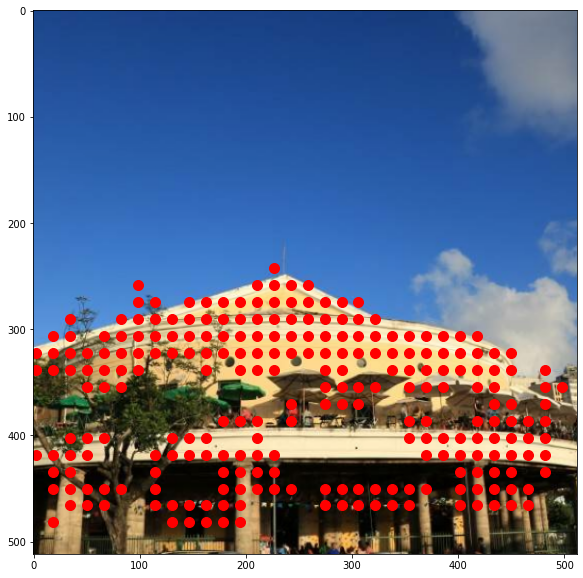

In [208]:
image = imported.extract_image(
    train_df.path[43], 
    dim=512, 
    central_crop=True, 
    crop_ratio=(0.7, 1.0)
)
    
features, points = imported.extract_local_descriptor(
    image, attention_threshold=175.0, nms_max_feature_num=1000, nms_iou_threshold=1.0)

plt.figure(figsize=(10, 10))
plt.imshow(image[0])

plt.scatter(points[:, 1], points[:, 0], s=100, c='red')

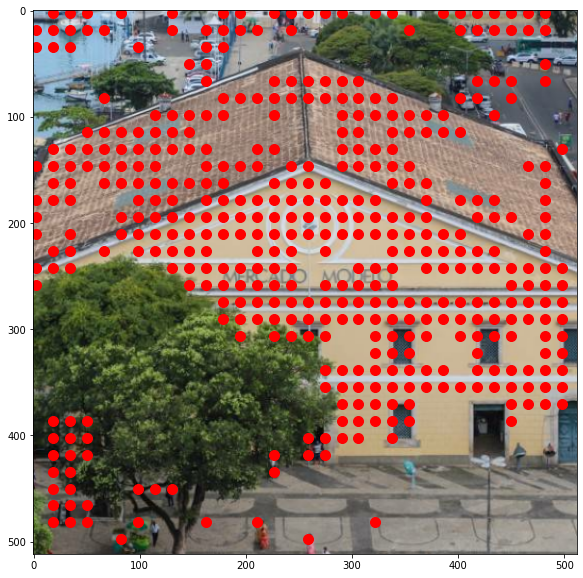

In [210]:
image = imported.extract_image(
    train_df.path[41], 
    dim=512, 
    central_crop=True, 
    crop_ratio=(0.7, 1.0)
)
    
features, points = imported.extract_local_descriptor(
    image, attention_threshold=175.0, nms_max_feature_num=1000, nms_iou_threshold=1.0)

plt.figure(figsize=(10, 10))
plt.imshow(image[0])

plt.scatter(points[:, 1], points[:, 0], s=100, c='red')

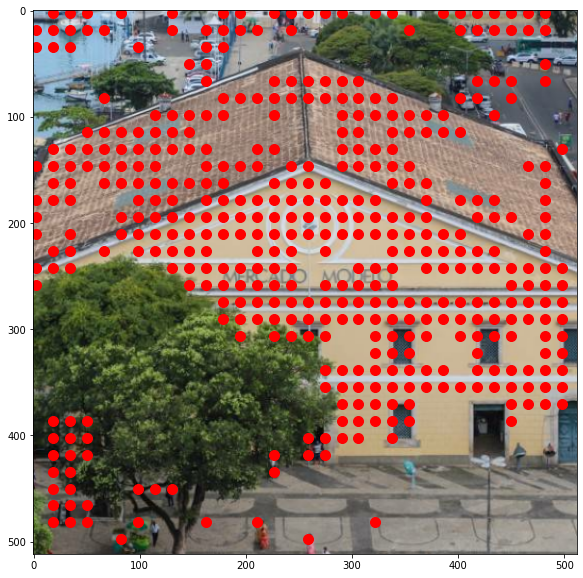

In [211]:
image = imported.extract_image(
    train_df.path[41], 
    dim=512, 
    central_crop=True, 
    crop_ratio=(0.7, 1.0)
)
    
out = imported.extract_local_prediction(image)

plt.figure(figsize=(10, 10))
plt.imshow(image[0])

plt.scatter(points[:, 1], points[:, 0], s=100, c='red')

In [212]:
out

<tf.Tensor: shape=(81313,), dtype=float32, numpy=
array([1.1414505e-17, 6.7797968e-16, 2.9148421e-16, ..., 5.1177591e-15,
       6.1702496e-16, 1.2925387e-19], dtype=float32)>

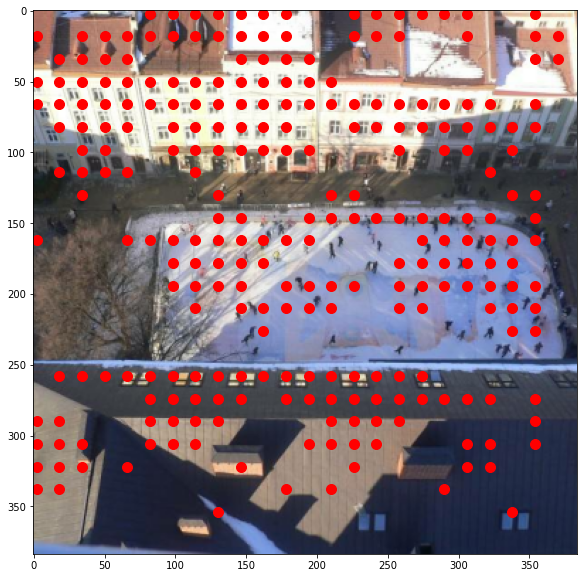